Lagrangian Tracer Bloom Model
==

Based on v00, not clear exactly what has changed aside from pointing to bloom_tracers_v01
rather than bloom_tracers_v09.

Later updated to point to newer bloom_tracers_v10 run.

2024-09-26: copied from plot_dfm_bloom_tracers_v04refactor, trying to streamline notebook, move some
code into separate py file

In [356]:
import matplotlib.pyplot as plt
%matplotlib widget

Support / Prep
==

In [357]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, memoize, xr_utils, xr_transect
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb, mkanim

from stompy.grid import unstructured_grid
from matplotlib import colors, cm
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp

import stompy.plot.cmap as scmap

from numba import njit
from stompy.spatial import field
from scipy import ndimage

from IPython.display import Video

import time
import six
import datetime
import glob
from stompy.plot import nbviz

In [358]:
# These online-coupled dfm-dwaq runs.
import bloom_common
#six.moves.reload_module(bloom_common)
from bloom_common import load_model, ratio
import tracer_group
six.moves.reload_module(tracer_group)
from tracer_group import TracerGroup


In [359]:
    
# Spinup
#run_dir="bloom_tracers_v01/run_20220801T0000_20220804T0000_v01"
# Main run
#run_dir="bloom_tracers_v01/run_20220804T0000_20220830T0000_v00"

# 2024-06-28: improved temperature field, 3 choices of swimming
#run_dir="bloom_tracers_v09/run_20220804T1820_20220830T0000_v01"
#swim_speeds=[5,10,0]

# 2024-07-10ish: fix bug in initial condition, small and large release from RS.
# Failed 3 days early due to full disk.
#run_dir="bloom_tracers_v10/run_20220804T1820_20220830T0000_v00"
#swim_speeds=[5,10,0,5,10,0]
#initial_conds=['alameda','alameda','alameda','southbay','southbay','southbay']

# no temperature run -- only 5 days in as of 2024-07-23
# run_dir="bloom_tracers_v11/run_20220804T1820_20220830T0000_v00"
# swim_speeds=[5,10,0,5,10,0]
# initial_conds=['alameda','alameda','alameda','southbay','southbay','southbay']

tracer_groups=[]

run_dir="bloom_tracers_v12/run_20220804T1820_20220830T0000_v00"

# 2024-08-30: v12 -- lots of tracers, uniform and chl_from_rs
# v12: lagrangian and uniform, includes diurnal swimming, 80um/day swimming
tracer_groups += [
    TracerGroup(tag='v12',suffix=0,run_dir=run_dir,swim=5,     initial='alameda'),
    TracerGroup(tag='v12',suffix=1,run_dir=run_dir,swim=10,    initial='alameda'),
    TracerGroup(tag='v12',suffix=2,run_dir=run_dir,swim=0,     initial='alameda'),
    TracerGroup(tag='v12',suffix=3,run_dir=run_dir,swim=6.912, initial='alameda'),
    TracerGroup(tag='v12',suffix=4,run_dir=run_dir,swim=6.912j,initial='alameda'),
    TracerGroup(tag='v12',suffix=5,run_dir=run_dir,swim=5,     initial='uniform'),
    TracerGroup(tag='v12',suffix=6,run_dir=run_dir,swim=10,    initial='uniform'),
    TracerGroup(tag='v12',suffix=7,run_dir=run_dir,swim=0,     initial='uniform'),
    TracerGroup(tag='v12',suffix=8,run_dir=run_dir,swim=6.912, initial='uniform'),
    TracerGroup(tag='v12',suffix=9,run_dir=run_dir,swim=6.912j,initial='uniform'),
]    


# v13: lagrangian, diurnal swimming with 80um/day, incl. linearized light
run_dir="bloom_tracers_v13/run_20220804T1820_20220830T0000_v01"
tracer_groups += [
    TracerGroup(tag='v13',suffix=0,run_dir=run_dir,swim=0,initial='alameda'),
    TracerGroup(tag='v13',suffix=1,run_dir=run_dir,swim=6.912,initial='alameda'),
    TracerGroup(tag='v13',suffix=2,run_dir=run_dir,swim=6.912j,initial='alameda'),
    TracerGroup(tag='v13',suffix=3,run_dir=run_dir,swim=0,initial='southbay'),
    TracerGroup(tag='v13',suffix=4,run_dir=run_dir,swim=6.912,initial='southbay'),
    TracerGroup(tag='v13',suffix=5,run_dir=run_dir,swim=6.912j,initial='southbay'),
]

Linearized Light Limitation
--

In [360]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]

ds=tg.model.map_dataset()

Text(0.02, 0.03, '2022-08-21 03:20 PDT')

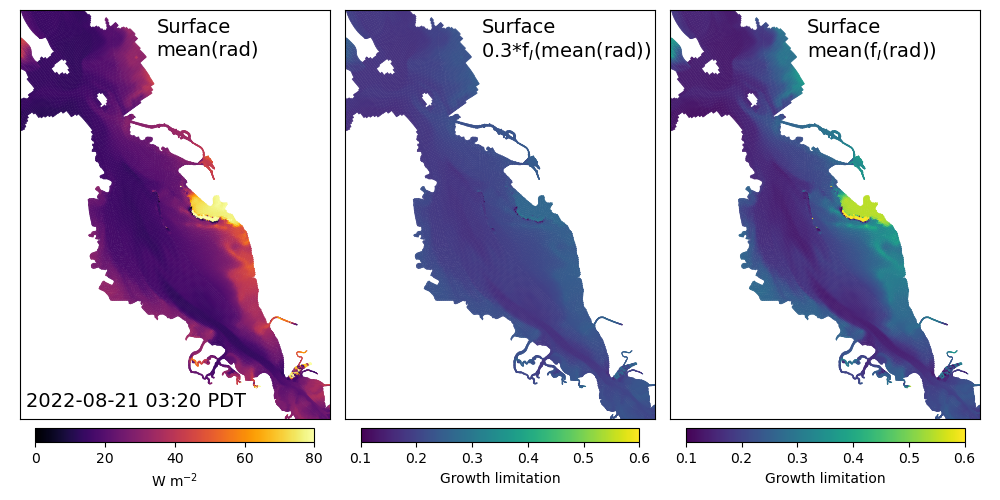

In [361]:
tidx=400

# First, the basic light limitation calculation:
layer="Surface"
sel=dict(time=tidx,laydim=15)
conc=tg['conc'].isel(**sel).values
radc=tg['radc'].isel(**sel).values
kradA=tg['kRadA'].isel(**sel).values
kradB=tg['kRadB'].isel(**sel).values

# DFM gets some negative concentrations. Slightly better to take abs of everything.
# For lagrangian model doesn't matter too much since concentration is quite low.
conc=np.abs(conc)
radc=np.abs(radc)
kradA=np.abs(kradA)
kradB=np.abs(kradB)

age=((tg.ds.time[tidx] - tg.ds.time[0])/np.timedelta64(24,'h')).item()
rad=ratio(radc, age*conc)
radA=ratio(kradA,age*conc)
radB=ratio(kradB,age*conc)
zoom=(544806.72535673, 584499.458477138, 4145536.190742454, 4197985.175969432)

Isat=10.0
fRad = radA

#Isat=20.0
#fRad = radB

panels=[
    #dict(scal=conc,clim=[1e-4,10],label='conc', cmap='turbo', norm=colors.LogNorm),
    dict(scal=rad,clim=[0,80],label='mean(rad)', cmap='inferno', units='W m$^{-2}$'),
    dict(scal=0.3*rad/(rad+Isat),clim=[0.1,0.6],label='0.3*f$_I$(mean(rad))',cmap='viridis', units='Growth limitation'),
    dict(scal=fRad,clim=[0.1,0.6],label='mean(f$_I$(rad))',cmap='viridis', units='Growth limitation')
]

fig,axs=plt.subplots(1,len(panels),figsize=(10,5))
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05)
for ax,panel in zip(axs,panels):
    ax.set_adjustable('datalim')
    ccoll=tg.grid.plot_cells(values=panel['scal'],cmap=panel.get('cmap','turbo'),
                             norm=panel.get('norm',colors.Normalize)(),
                             lw=0.5,ec='face',clim=panel['clim'],ax=ax)
    plt.colorbar(ccoll,orientation='horizontal',label=panel.get('units',''),shrink=0.9,fraction=0.1,pad=0.02)
    ax.text(0.44,0.98,f"{layer}\n{panel['label']}",
            fontsize=14,transform=ax.transAxes,va='top')

    ax.axis(zoom)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)

axs[0].text(0.02,0.03,utils.strftime(ds.time[400].values - np.timedelta64(7,'h'),
                                     "%Y-%m-%d %H:%M PDT"),
            fontsize=14,transform=axs[0].transAxes)

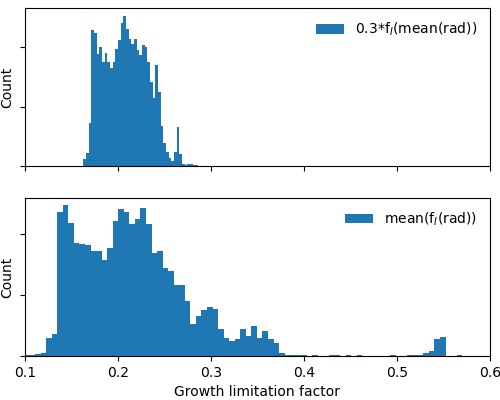

In [362]:
# Histogram, too
fig,axs=plt.subplots(2,1,sharex=True,figsize=(5,4))
cell_sel = tg.grid.cell_clip_mask(zoom)
for ax,panel in zip(axs,panels[1:]):
    scal=panel['scal'][cell_sel]
    scal=scal[ np.isfinite(scal) & (scal>0) & (scal<0.6) ]
    ax.hist(scal,label=panel['label'],bins=100)
    ax.legend(loc='upper right',frameon=0)

    plt.setp(ax.get_yticklabels(),visible=0)
    ax.set_ylabel('Count')
ax.set_xlabel('Growth limitation factor')
ax.axis(xmin=0.1,xmax=0.6)
fig.subplots_adjust(left=0.05,right=0.98,top=0.98)

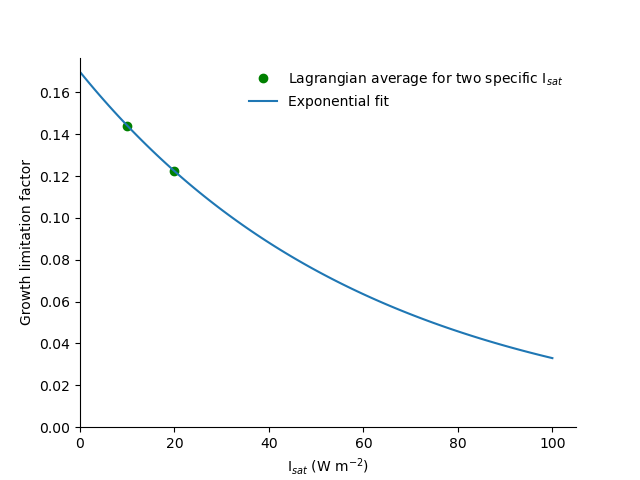

In [363]:
# Interpolation of fLim data points
# Say we 
pnt=[566200,4.1595e6]
cell=tg.grid.select_cells_nearest(pnt)

IsatA=10.0
IsatB=20.0
fA=radA[cell]
fB=radB[cell]

Isat=np.linspace(0,100,100)

# Linear interpolation
fIsat_lin = fA + (Isat-IsatA)/(IsatB-IsatA)*(fB-fA)

# But we know that as Isat goes to inf, should asymptote to 0.0,
# and as Isat goes to zero, should asymptote to 0.5 (as a nod to diurnal)
f0=0.17
kIsat=0.015
# fI_exp = f0*np.exp(-kI*I)
# log(fI_exp)  = -kI*I + log(f0)
kIsat,log_f0 = np.polyfit(np.r_[IsatA,IsatB],np.log(np.r_[fA,fB]),1)
f0=np.exp(log_f0)
fIsat_exp = f0*np.exp(kIsat*Isat)

fig,ax=plt.subplots()
ax.plot([IsatA,IsatB],[fA,fB],'go',label='Lagrangian average for two specific I$_{sat}$')
#ax.plot(Isat,fIsat_lin,'g-',label='Linear interpolation')
ax.plot(Isat,fIsat_exp,label='Exponential fit')

ax.set_xlabel('I$_{sat}$ (W m$^{-2}$)')
ax.set_ylabel('Growth limitation factor') 
ax.legend(loc='upper right',frameon=0)
ax.axis(ymin=0.0,xmin=0.0)
ax.spines['top'].set_visible(0)
ax.spines['right'].set_visible(0)

Lagrangian Model
--

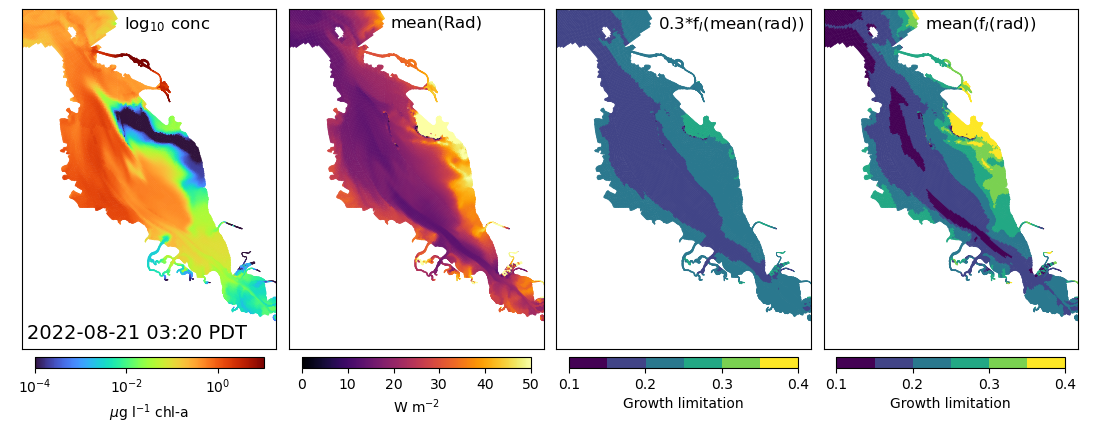

In [364]:
fig=tg.figure_fields(tidx=400,
                     fields=['logConc','meanRad','fMeanRad','meanFRadA'],
                     zoom=(550862., 582466., 4.14e6, 4.19e6)
                     )

In [59]:
from stompy import memoize

@memoize.memoize(lru=1)
def extract_tracers(tidx,layer,Isat=10.0,thresh=1e-5,group=0):
    # Extraction
    # instantaneous release, so age is a given.
    t=ds.time.isel(time=tidx).values
    age_d = (t - ds.time.values[0]) / np.timedelta64(86400,'s')
    
    if layer=='mean':
        snap=ds.isel(time=tidx)
        conc = snap[f'conc{group}'].values.mean(axis=1).clip(0,np.inf)

        # These should be about the same, not sure why one would be preferable over the
        # other.
        #Imean =  ratio( snap['radc0'].values, snap['agec0'].values, thresh)
        Imean = ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
            
        kLight = (Imean/(Imean + Isat)).mean(axis=1) # happen to know that layer is the second dimension    
    else:
        snap=ds.isel(time=tidx,laydim=layer)
        conc  = snap[f'conc{group}'].values
    
        # average irradiance accounting for Kd, vertical mixing.
        Imean = ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
        # This could be averaged over the layers instead.
        kLight = Imean/(Imean + Isat)

    #Imean[np.isnan(Imean)]=0.0 
    #kLight = fill(kLight, iterations=120)
    print(f"kLight: {np.isnan(kLight).sum()} missing values, thresh={thresh}")
    return dict(age_d=age_d, conc=conc, kLight=kLight, Imean=Imean, t=t)  


In [60]:
# Panel for P and a panel for N.

def solveNP(thresh=1e-5,
            # Parameters:
            c0 = 50,
            tidx = 20, 
            Isat=20., 
            N0=35, # initial DIN
            Nsat=0.5,
            kprod=0.7, # per day. high!
            kmort=0.1,
            alpha=0.15, # stoichiometry, uM DIN per ug/l chl production.
            layer='mean',
            group=0):
    tracers=extract_tracers(tidx=tidx, layer=layer, Isat=Isat, thresh=thresh, group=group)
    kLight = tracers['kLight']
    conc = c0*tracers['conc']
    age_d = tracers['age_d']
    Imean = tracers['Imean']
    t = tracers['t']

    sel = np.isfinite(kLight * conc * age_d)
    kLight = kLight[sel]
        
    # ODE integration
    # State vector is [ P[0].... P[i], N[0], ... , N[i] ]
    def diff(t,state):
        P,N=state.reshape([2,-1])
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        kDIN=N/(N+Nsat)
        dgrossP = kprod*kLight*kDIN*P
        dnetP = -kmort*P + dgrossP
        dN = -alpha*dgrossP
        mu_net = kprod*kLight*kDIN - kmort
        return np.r_[dnetP,dN]
    IC=np.r_[conc[sel], N0*np.ones_like(conc)[sel]]

    print("IC shape: ", IC.shape) # 2*Ncells
    
    # odeint was buggy.
    #result = odeint(diff, IC, [0,age_d], hmax=0.1)
    bunch = solve_ivp(diff, y0=IC, t_span=[0,age_d])
    result=bunch.y[:,-1]
    Psel,Nsel = result.reshape([2,-1])
    # expand
    if 1:
        # assume no biomass, no depletion of N when conc too small.
        P = np.full(conc.shape,0.0)
        N = np.full(conc.shape,N0)
    else:
        # Make it clear where data is missing
        P = np.full(conc.shape,np.nan)
        N = np.full(conc.shape,np.nan)
        
    P[sel]=Psel
    N[sel]=Nsel
    
    ds=xr.Dataset()
    ds['N'] = ('cell',), N
    ds['P'] = ('cell',), P
    ds['time'] = (),t

    ds['c0'] = (),c0
    ds['Isat'] = (),Isat
    ds['N0'] = (),N0
    ds['Nsat'] = (),Nsat
    ds['kprod'] = (), kprod
    ds['kmort'] = (), kmort
    ds['alpha'] = (), alpha
    ds['layer'] = (), layer
    
    return ds

In [61]:
import stompy.plot.cmap as scmap
import matplotlib.colorbar as cbar

from matplotlib import cm
turbo_low = scmap.cmap_transform(cm.turbo,lambda i: i**0.75)

In [66]:
#rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_3"

# 2024-09-11: 07_reproject_3 no longer exists.
#rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_3"
# Assuming this is best to use:
rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_re10_sfei"


def chl_from_RS(t):
    #scene="20220804_S3A_OL_NT_CHL_LOG10.img" # bloom not that obvious.
    #scene="20220805_S3B_OL_NT_CHL_LOG10.img" # lots of clouds
    #scene="20220806_S3B_OL_NT_CHL_LOG10.img" # lots of clouds

    patt = os.path.join(rs_chl_dir, f"{utils.strftime(t,'%Y%m%d')}_S3*_OL_NT_CHL_LOG10.img")
    hits=glob.glob(patt)
    if not hits:
        return None
    #scene="20220807_S3A_OL_NT_CHL_LOG10.img" # decent, though getting late.
    #rs_chl_fn=os.path.join(rs_chl_dir,scene)
    rs_chl_fn=hits[0]
    rs_chl_log10 = field.GdalGrid(rs_chl_fn)
    
    # clip and remove specks.    
    valid = np.isfinite(rs_chl_log10.F)
    valid = valid & rs_chl_log10.polygon_mask(grid_poly) 
    rs_chl_log10.F[~valid]=np.nan
    rs_chl_log10.F = ndimage.median_filter(rs_chl_log10.F,size=3)
    # rs_chl_log10.F[ rs_chl_log10.F<1.0 ] = 0.0
        
    chl_IC = rs_chl_log10.copy()
    chl_IC.F = 10**chl_IC.F    
        
    return chl_IC

kLight: 31461 missing values, thresh=0.01
IC shape:  (37070,)


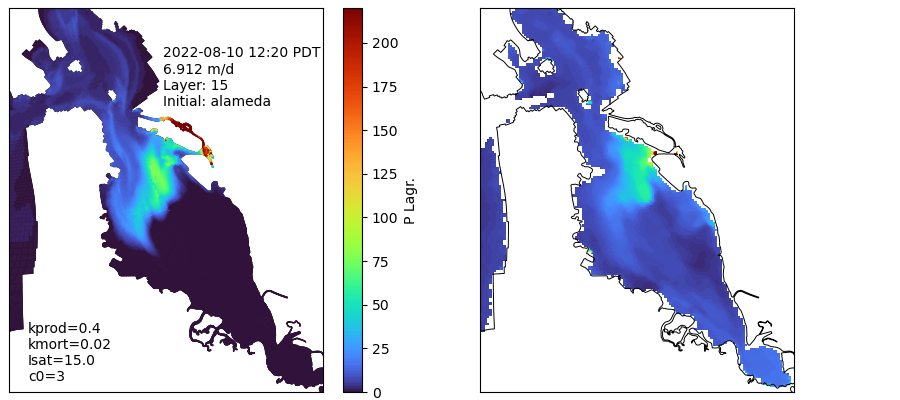

In [100]:
# Lagrangian vs. RS chl

#tidx=73 # 8/7 noon
#tidx=97 # 8/8
#tidx=121
tidx=145 # 8/10
#tidx=169 # 8/11
#tidx=193 # 8/12
#tidx=217 # 8/13
#tidx=241 # 8/14
#tidx=385 # 8/20
#tidx=409 # 8/21
#tidx=433 # 8/22 12:20

# What does it take to get a bloom if I apply the 0.4 attenuation factor
# for light distribution, and a fixed 0.7 g_max?

t=ds.time.values[tidx]

rs_chl = chl_from_RS(t)

for group in [3]: # [2,0,1]:
    for layer in [15]:
        result = solveNP(tidx=tidx, group=group, layer=layer, 
                         thresh=1e-2, 
                         c0=3, 
                         kprod=0.4, # 0.4*0.95,
                         N0=45, # initial DIN, uM
                         Nsat=0.5, # half-sat DIN, uM
                         kmort=0.02,
                         Isat=15.0)
        
        fig,axs=plt.subplots(1,2,figsize=(9,4))
        fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
        axP,axRS = axs
        caxs=[cbar.make_axes(ax)[0] for ax in axs]
        
        kw=dict(lw=0.5,edgecolor='face')
        clim=[0,220]
        cmap=turbo_low

        for ax in axs:
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)

        if 1: # Lagrangian model output
            ccoll=ds.grid.plot_cells( values=result.P, ax=axP, cmap=cmap, **kw)
            ccoll.set_clim(clim)
            plt.colorbar(ccoll,label='P Lagr.',ax=axP,cax=caxs[0])

            if np.isreal(swim_speeds[group]):
                swimming=f"{swim_speeds[group]} m/d"
            else:
                swimming=f"{np.imag(swim_speeds[group])} m/d diurnal"
                
            txt="\n".join([utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                           swimming,
                           f"Layer: {layer}",
                           f"Initial: {initial_conds[group]}"])
            axP.text(0.49,0.9, txt, va='top',
                     transform=axP.transAxes)

            param_txt=[]
            for fld in ['kprod','kmort','Isat','c0']:
                param_txt.append( f"{fld}={result[fld].values}" )
            param_txt="\n".join(param_txt)
            axP.text(0.06,0.02, param_txt, va='bottom',
                     transform=axP.transAxes)
            
        if rs_chl is not None: # RS scene
            rs_chl.plot(ax=axRS,cmap=cmap,clim=clim)
            caxs[1].set_visible(0)
        else:
            axRS.text(0.5,0.5,"No RS data",transform=axRS.transAxes, ha='center')
            
        for ax in axs:
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))


IC shape:  (89924,)


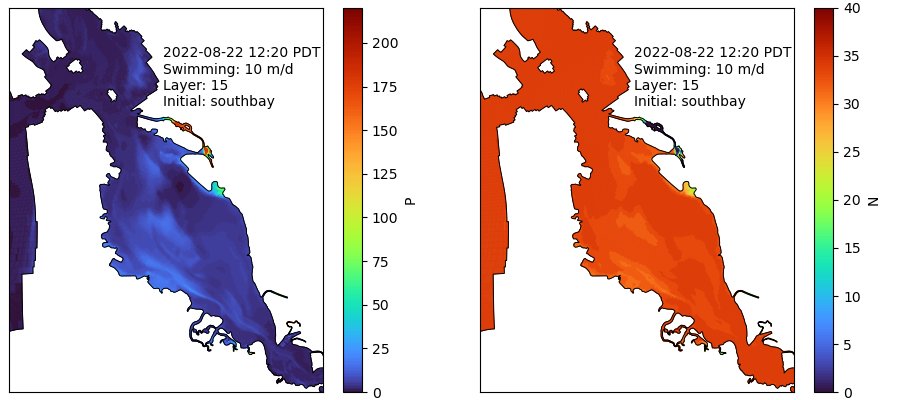

In [50]:

#tidx=97-24 # 8/7 noon
#tidx=97
#tidx=121
tidx=433 # 8/22 12:20

# What does it take to get a bloom if I apply the 0.4 attenuation factor
# for light distribution, and a fixed 0.7 g_max?

for group in [4]: # [2,0,1]:
    for layer in [15]:
        result = solveNP(c0=1.0, tidx=tidx, group=group, layer=layer, kprod=0.4*0.7, kmort=0.05,
                         thresh=1e-2)
        
        fig,axs=plt.subplots(1,2,figsize=(9,4))
        fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
        axP,axN = axs
        caxs=[cbar.make_axes(ax)[0] for ax in axs]
        
        kw=dict(lw=0.5,edgecolor='face')
        
        for ax,cax,plot in zip(axs,caxs,[
            dict(scal=result.P,label='P',clim=[0,220],cmap=turbo_low),
            dict(scal=result.N,label='N',clim=[0,40],cmap='turbo')
        ]):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax, cmap=plot['cmap'], **kw)
            ccoll.set_clim(plot['clim'])
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],cax=cax)
            # ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
            txt="\n".join([utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                           f"Swimming: {swim_speeds[group]} m/d",
                           f"Layer: {layer}",
                           f"Initial: {initial_conds[group]}"])
            ax.text(0.49,0.9, txt, va='top',
                    transform=ax.transAxes)

Group: 0  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICalameda
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICalameda/lagra_v00_5mpd_ICalameda.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 48751 missing values, thresh=0.01
IC shape:  (2490,)
kLight: 48498 missing values, thresh=0.01
IC shape:  (2996,)
kLight: 48236 missing values, thresh=0.01
IC shape:  (3520,)
kLight: 47966 missing values, thresh=0.01
IC shape:  (4060,)
kLight: 47715 missing values, thresh=0.01
IC shape:  (4562,)
kLight: 47566 missing values, thresh=0.01
IC shape:  (4860,)
kLight: 47438 missing values, thresh=0.01
IC shape:  (5116,)
kLight: 47398 missing values, thresh=0.01
IC shape:  (5196,)
kLight: 47439 missing values, thresh=0.01
IC shape:  (5114,)
kLight: 47512 missing values, thresh=0.01
IC shape:  (4968,)
kLight: 47570 missing values, thresh=0.01
IC shape:  (4852,)
kLight: 47630 missing values, thresh=0.01
IC sh

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 1  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICalameda
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICalameda/lagra_v00_10mpd_ICalameda.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 48747 missing values, thresh=0.01
IC shape:  (2498,)
kLight: 48493 missing values, thresh=0.01
IC shape:  (3006,)
kLight: 48226 missing values, thresh=0.01
IC shape:  (3540,)
kLight: 47960 missing values, thresh=0.01
IC shape:  (4072,)
kLight: 47705 missing values, thresh=0.01
IC shape:  (4582,)
kLight: 47544 missing values, thresh=0.01
IC shape:  (4904,)
kLight: 47412 missing values, thresh=0.01
IC shape:  (5168,)
kLight: 47377 missing values, thresh=0.01
IC shape:  (5238,)
kLight: 47408 missing values, thresh=0.01
IC shape:  (5176,)
kLight: 47487 missing values, thresh=0.01
IC shape:  (5018,)
kLight: 47547 missing values, thresh=0.01
IC shape:  (4898,)
kLight: 47607 missing values, thresh=0.01
IC

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 2  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICalameda
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICalameda/lagra_v00_0mpd_ICalameda.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 48757 missing values, thresh=0.01
IC shape:  (2478,)
kLight: 48506 missing values, thresh=0.01
IC shape:  (2980,)
kLight: 48245 missing values, thresh=0.01
IC shape:  (3502,)
kLight: 47976 missing values, thresh=0.01
IC shape:  (4040,)
kLight: 47731 missing values, thresh=0.01
IC shape:  (4530,)
kLight: 47585 missing values, thresh=0.01
IC shape:  (4822,)
kLight: 47466 missing values, thresh=0.01
IC shape:  (5060,)
kLight: 47425 missing values, thresh=0.01
IC shape:  (5142,)
kLight: 47465 missing values, thresh=0.01
IC shape:  (5062,)
kLight: 47547 missing values, thresh=0.01
IC shape:  (4898,)
kLight: 47603 missing values, thresh=0.01
IC shape:  (4786,)
kLight: 47661 missing values, thresh=0.01
IC sh

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 3  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICsouthbay
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICsouthbay/lagra_v00_5mpd_ICsouthbay.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 46478 missing values, thresh=0.01
IC shape:  (7036,)
kLight: 46244 missing values, thresh=0.01
IC shape:  (7504,)
kLight: 45795 missing values, thresh=0.01
IC shape:  (8402,)
kLight: 45014 missing values, thresh=0.01
IC shape:  (9964,)
kLight: 44156 missing values, thresh=0.01
IC shape:  (11680,)
kLight: 43387 missing values, thresh=0.01
IC shape:  (13218,)
kLight: 42842 missing values, thresh=0.01
IC shape:  (14308,)
kLight: 42445 missing values, thresh=0.01
IC shape:  (15102,)
kLight: 42215 missing values, thresh=0.01
IC shape:  (15562,)
kLight: 41831 missing values, thresh=0.01
IC shape:  (16330,)
kLight: 41392 missing values, thresh=0.01
IC shape:  (17208,)
kLight: 40669 missing values, thresh=

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 4  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICsouthbay
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICsouthbay/lagra_v00_10mpd_ICsouthbay.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 46459 missing values, thresh=0.01
IC shape:  (7074,)
kLight: 46222 missing values, thresh=0.01
IC shape:  (7548,)
kLight: 45767 missing values, thresh=0.01
IC shape:  (8458,)
kLight: 44964 missing values, thresh=0.01
IC shape:  (10064,)
kLight: 44085 missing values, thresh=0.01
IC shape:  (11822,)
kLight: 43314 missing values, thresh=0.01
IC shape:  (13364,)
kLight: 42737 missing values, thresh=0.01
IC shape:  (14518,)
kLight: 42329 missing values, thresh=0.01
IC shape:  (15334,)
kLight: 42112 missing values, thresh=0.01
IC shape:  (15768,)
kLight: 41777 missing values, thresh=0.01
IC shape:  (16438,)
kLight: 41342 missing values, thresh=0.01
IC shape:  (17308,)
kLight: 40624 missing values, thr

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 5  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICsouthbay
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICsouthbay/lagra_v00_0mpd_ICsouthbay.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 46494 missing values, thresh=0.01
IC shape:  (7004,)
kLight: 46270 missing values, thresh=0.01
IC shape:  (7452,)
kLight: 45850 missing values, thresh=0.01
IC shape:  (8292,)
kLight: 45071 missing values, thresh=0.01
IC shape:  (9850,)
kLight: 44220 missing values, thresh=0.01
IC shape:  (11552,)
kLight: 43471 missing values, thresh=0.01
IC shape:  (13050,)
kLight: 42955 missing values, thresh=0.01
IC shape:  (14082,)
kLight: 42562 missing values, thresh=0.01
IC shape:  (14868,)
kLight: 42299 missing values, thresh=0.01
IC shape:  (15394,)
kLight: 41913 missing values, thresh=0.01
IC shape:  (16166,)
kLight: 41449 missing values, thresh=0.01
IC shape:  (17094,)
kLight: 40725 missing values, thresh=

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

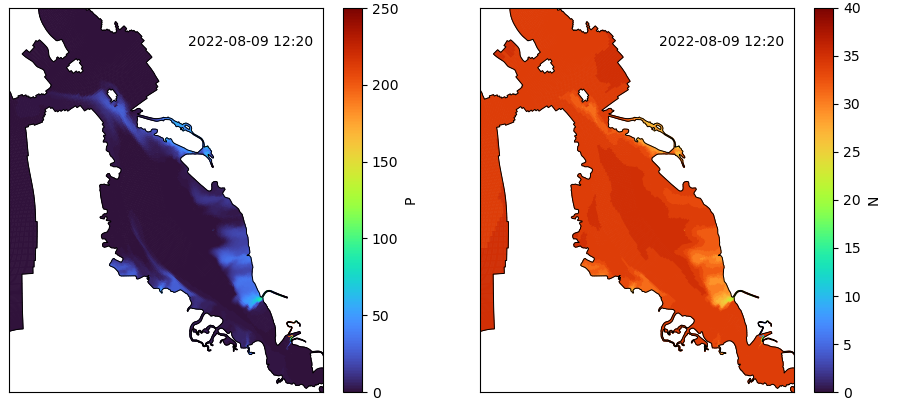

In [40]:
# Animation
fig,axs=plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
axP,axN = axs
caxs=[cbar.make_axes(ax)[0] for ax in axs]

for group in [0,1,2,3,4,5]:
    frame_dir=os.path.join(run_dir,f"frames_v00_{swim_speeds[group]}mpd_IC{initial_conds[group]}")
    movie_fn=os.path.join(frame_dir,f"lagra_v00_{swim_speeds[group]}mpd_IC{initial_conds[group]}.mp4")

    print(f"Group: {group}  Output to {frame_dir}")
    print(f"   movie file: {movie_fn}")
    updated=False
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    
    for ax in axs:
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
    
    for tidx in range(ds.dims['time']):
        img_fn=os.path.join(frame_dir,"frame_%04d.png"%tidx)
        if os.path.exists(img_fn):
            continue
            
        result = solveNP(tidx=tidx,group=group, c0=1.0, layer=15, kprod=0.6, kmort=0.05, thresh=1e-2)
    
        axP.cla()
        axN.cla()
        
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')
        
        for ax,cax,plot in zip(axs,caxs,[
            dict(scal=result.P,label='P',clim=[0,250]),
            dict(scal=result.N,label='N',clim=[0,40])
        ]):
            ax.cla()
            cax.cla()
            
            ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
            ccoll.set_clim(plot['clim'])
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],cax=cax)
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
            ax.text(0.57,0.9, utils.strftime(result.time), transform=ax.transAxes)
        fig.savefig(img_fn,dpi=100)
        updated=True


    # Compile to animation
    import subprocess
    if os.path.exists(movie_fn):
        if not updated:
            continue
        os.unlink(movie_fn)
    subprocess.run(f"ffmpeg -framerate 10 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                    "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
                   f"-pix_fmt yuv420p -crf 20 -r 10 {movie_fn}",
                   shell=True)


In [57]:
# Thinking about distribution of insolation, and ways of approximating 
# synthesize time series of Rad
c=35119
Qsun=ds['Qsun'].isel(nFlowElem=c).values


In [62]:
depth = np.linspace(0,4,len(Qsun))
Kd=1.5
atten = np.exp(-depth*Kd)
rad_synth = Qsun * atten

Correction factor 0.400


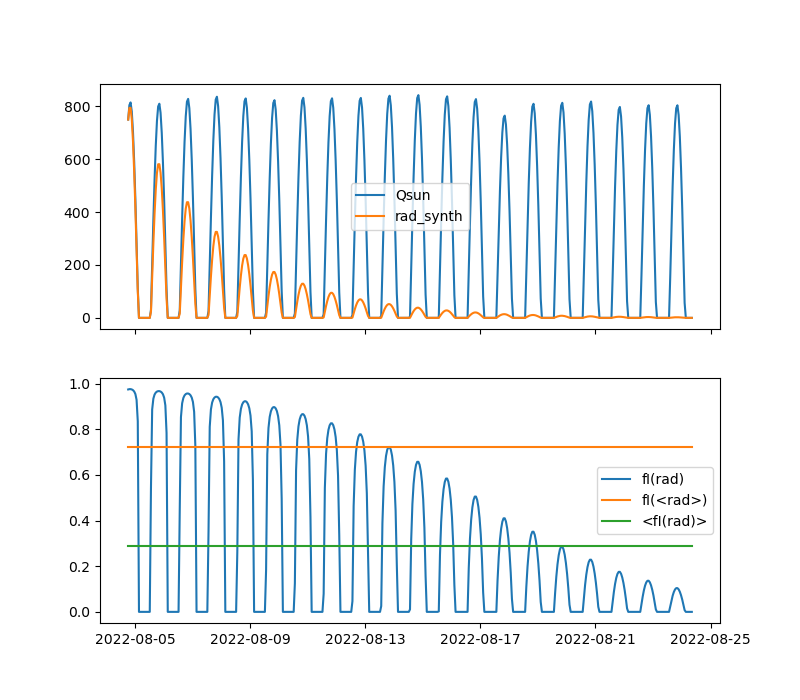

In [68]:
fig,(ax,ax_fI) = plt.subplots(2,1,sharex=True,figsize=(8,7))

ax.plot(ds.time, Qsun, label='Qsun')
ax.plot(ds.time, rad_synth, label='rad_synth')

Isat = 20.0
def fI(I):
    # 0.4
    return I/(I+Isat)

#def fI(I):
#    # 0.443
#    return I/Isat * np.exp(1-I/Isat)

ax_fI.plot(ds.time, fI(rad_synth), label='fI(rad)')
ax_fI.plot(ds.time, np.ones_like(rad_synth) * fI(rad_synth.mean()), label='fI(<rad>)')
ax_fI.plot(ds.time, np.ones_like(rad_synth) * fI(rad_synth).mean(), label='<fI(rad)>')

correction = fI(rad_synth).mean() / fI(rad_synth.mean())
print(f"Correction factor {correction:.3f}")

ax.legend()
ax_fI.legend()

In [302]:
Video(movie_fn) 

Slice Plots
--

In [224]:
# line from W span of bay bridge to about Redwood City
from shapely import wkt
profile_geom_channel=wkt.loads("""
LineString (553934.46602910873480141 4185292.98902965523302555, 556003.0745520245982334 4182475.40155878709629178,
557144.37580604711547494 4180335.46170749515295029, 557964.68608237581793219 4178231.18752039084210992, 
558250.01139588153455406 4176198.24466166319325566, 558606.66803776356391609 4172631.67824284266680479,
559248.64999315119348466 4169279.10580915166065097, 560211.62292623275425285 4166283.19001734210178256,
561994.90613564301747829 4163750.92785997968167067, 563706.85801667685154825 4161896.31332219298928976,
565882.46353215735871345 4159970.36745603010058403, 568129.40037601429503411 4158650.73788106627762318,
571089.65050363529007882 4156831.78900746814906597, 573728.90965356235392392 4154406.52384267002344131)
""") 

# similar northern run, but in the middle of San Bruno Shoal head out across the shoal
profile_geom_shoal=wkt.loads("""
LineString (553943.43526522838510573 4185306.34642233327031136, 555905.91317636473104358 4182700.43313049618154764, 
557064.09686162555590272 4180319.72222190443426371, 557932.7346255712909624 4178099.8701584879308939, 
558318.79585399152711034 4175686.98748086113482714, 558447.48293013160582632 4174046.2272600750438869, 
558994.40300372685305774 4171392.05631468491628766, 560184.75845802284311503 4169477.83605710230767727,
562565.46936661447398365 4168030.10645052650943398, 570930.12931572052184492 4165456.3649277244694531,
574211.64975729293655604 4164716.4142399188131094)
""")

tidx=10
tg = [t for t in tracer_groups if t.tag=='v12' and t.swim==6.912j and t.initial=='uniform'][0]

profile_name="channel"
tran = tg.extract_transect(profile_geom_channel, 10)



In [225]:
tg.tracer_short_name

'conc9_6.9mpd_diurnal_uniform'

In [226]:
class SliceAnimation:
    save=True
    tg=None # tracer group

    profile_name=None
    linestring=None
    normalize = True
    force = False
    render_mp4=True
    mp4_settings=[dict(name='_12fps',fps=12),
                  dict(name='_6fps',fps=6)]
    
    def __init__(self,tg,**kw):
        self.tg=tg
        utils.set_keywords(self,kw)
        
        if self.save:
            frame_dir=os.path.join(tg.run_dir,f'slice_frames_{self.profile_name}_{self.tg.tracer_short_name}_v0')
            if not os.path.exists(frame_dir):
                os.makedirs(frame_dir)
            if self.force:
                [os.unlink(f) for f in glob.glob(os.path.join(frame_dir,'*.png'))]
        
            patt=os.path.join(frame_dir,'frame_%04d.png')
        
            plt.ioff()
            tidxs=range(self.tg.ds.dims['time'])
        else:
            tidxs=[-1]

        tracer='conc' # tg will have dropped suffix number

        cell_ref = self.tg.grid.select_cells_nearest(self.linestring.coords[0])
        depth_ref = self.tg.ds['s1'].isel(nFlowElem=cell_ref)
        
        for tidx in tidxs:
            if self.save:
                img_fn=patt%tidx
                if os.path.exists(img_fn) and not self.force:
                    continue
                    
            print(tidx)
            tran=self.tg.extract_transect(self.linestring,tidx)
        
            if self.normalize: # normalize depth-averaged concentration.
                tran[tracer] /= tran[tracer].mean(dim='layer')
        
            fig,axs=plt.subplots(2,1,figsize=(8.5,5), height_ratios=[0.7,0.3])
            ax=axs[0]
            ax_t=axs[-1]
            ax_d=ax_t.twinx()
        
            ccoll=xr_transect.plot_scalar(tran, tracer, ax=ax,cmap='turbo')
            
            if self.normalize:
                ccoll.set_clim([0.5,2.0] )
                
            ax_d.plot(ds.time, depth_ref)
            ax_d.axvline(ds.time.values[tidx],color='k')
        
            dnum_pdt=utils.to_dnum( ds.time.values-np.timedelta64(7,'h'))
            daylight=(-np.cos(dnum_pdt*2*np.pi)).clip(0)
        
            ax_t.fill_between(ds.time,daylight,zorder=-1,fc='yellow',ec='k',lw=0.5)
        
            for ax in axs[:-1]:
                ax.axis(xmin=tran.d_sample.values[0],xmax=tran.d_sample.values[-1],ymin=-34,ymax=3.0)
            ax_t.axis(ymin=0,xmin=ds.time.values[0], xmax=ds.time.values[-1])
            ax_t.yaxis.set_visible(0)
                    
            fig.autofmt_xdate()
            fig.subplots_adjust(top=0.98,right=0.85,left=0.085,bottom=0.12)
            
            cax=fig.add_axes( [0.89, ax.get_position().ymin, 0.02,
                               ax.get_position().height] )
            plt.colorbar(ccoll, cax=cax)
        
            if self.save:
                fig.savefig(img_fn)
                plt.close(fig)
        
        if self.save:
            plt.ion()
            if self.render_mp4:
                for mp4_setting in self.mp4_settings:
                    mp4_fn=os.path.join(frame_dir,
                                        f'slice_anim_{self.profile_name}_{self.tg.tracer_short_name}_{mp4_setting["name"]}.mp4')
                    if os.path.exists(mp4_fn):
                        if self.force:
                            os.unlink(mp4_fn)
                        else:
                            continue
                    mkanim.mkanim(mp4_fn,patt,fps=mp4_setting['fps'])

SliceAnimation(save=True,tg=tg,profile_name='channel',linestring=profile_geom_channel)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [215]:
Video('bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/slice_frames_channel_conc8_6.9mpd_uniform_v0/slice_anim_channel_conc8_6.9mpd_uniform__12fps.mp4')